In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [4]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [5]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [6]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [20]:
def cross_validation(x_train, k=5):
    index = list(range(k)) * int(len(x_train)/k) # index table
    if((len(x_train)%k)!=0): # if not dividable: add index
        print("not factor ",(len(x_train)%k))
        for j in range(len(x_train)%k):
            index.append(j)
    np.random.shuffle(index) # shuffle
    fold = [] # store fold
    for i in range(k):
        temp_train = []
        temp_val = []
        for n in range(len(index)):
            if(index[n]==i):
                temp_val.append(n) # validation data
            else:
                temp_train.append(n) # train data
        fold.append([np.array(temp_train), np.array(temp_val)])
    fold = np.array(fold, dtype=object)
    return fold

In [77]:
kfold_data = cross_validation(x_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [67]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  3  4  6  7 10 11 12 13 14 15 16 17 18], Validation index: [ 5  8  9 19]
Split: 2, Training index: [ 0  1  3  5  6  8  9 10 11 12 13 14 15 16 17 19], Validation index: [ 2  4  7 18]
Split: 3, Training index: [ 0  1  2  4  5  6  7  8  9 10 11 12 15 17 18 19], Validation index: [ 3 13 14 16]
Split: 4, Training index: [ 0  2  3  4  5  7  8  9 10 12 13 14 16 17 18 19], Validation index: [ 1  6 11 15]
Split: 5, Training index: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 18 19], Validation index: [ 0 10 12 17]


In [68]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [69]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [78]:
x = cross_validation(x_train, k=5) 
print(x)

[[array([   0,    1,    2, ..., 6996, 6997, 6998])
  array([   7,    8,   20, ..., 6988, 6995, 6999])]
 [array([   1,    2,    3, ..., 6996, 6998, 6999])
  array([   0,    6,   18, ..., 6992, 6993, 6997])]
 [array([   0,    3,    4, ..., 6997, 6998, 6999])
  array([   1,    2,   12, ..., 6990, 6991, 6994])]
 [array([   0,    1,    2, ..., 6995, 6997, 6999])
  array([   5,    9,   10, ..., 6984, 6996, 6998])]
 [array([   0,    1,    2, ..., 6997, 6998, 6999])
  array([   3,    4,   14, ..., 6985, 6987, 6989])]]


In [122]:
def index_transformer(cv_list, x_data, y_data): # get data by index table 
    data_train = []
    data_val = []
    for i in cv_list:
        train_x = [x_data[n] for n in i[0]]
        train_y = [y_data[n] for n in i[0]]
        val_x = [x_data[n] for n in i[1]]
        val_y = [y_data[n] for n in i[1]]
        train_x = np.array(train_x)
        train_y = np.array(train_y)
        val_x = np.array(val_x)
        val_y = np.array(val_y)
        data_train.append([train_x, train_y])
        data_val.append([val_x, val_y])
        print(train_x.shape)
    return data_train, data_val


In [123]:
index_list = cross_validation(x_train, k=5)
train_list, val_list = index_transformer(index_list, x_train, y_train)
print(len(train_list), len(val_list))

(5600, 300)
(5600, 300)
(5600, 300)
(5600, 300)
(5600, 300)
5 5


In [124]:
## your code

best = [0, 0, 0] #accuracy, gamma, c
score_list = []
gamma = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
c = [0.1, 1, 10, 100, 1000, 10000]
for g_val in gamma: # loop all gamma & c pairs 
    for c_val in c:
        clf = SVC(C=c_val, kernel='rbf', gamma=g_val)
        cur_score = 0
        for d in range(len(train_list)): 
            clf.fit(train_list[d][0], train_list[d][1])
            cur_score = cur_score + clf.score(val_list[d][0], val_list[d][1])
        mean_score = cur_score/len(train_list)
        score_list.append([mean_score, g_val, c_val])
        if(mean_score>best[0]):
            best = [mean_score, g_val, c_val]

print("best: ", best)
print("all score: ", score_list)
        

#clf.fit(x_train, y_train)
#print(clf.score(x_train, y_train))

best:  [0.9934285714285714, 0.0001, 1]
all score:  [[0.49485714285714283, 1e-06, 0.1], [0.9081428571428571, 1e-06, 1], [0.9371428571428572, 1e-06, 10], [0.9465714285714286, 1e-06, 100], [0.9755714285714285, 1e-06, 1000], [0.9874285714285713, 1e-06, 10000], [0.9138571428571428, 1e-05, 0.1], [0.9535714285714285, 1e-05, 1], [0.9838571428571429, 1e-05, 10], [0.9908571428571428, 1e-05, 100], [0.9907142857142857, 1e-05, 1000], [0.9907142857142857, 1e-05, 10000], [0.9755714285714285, 0.0001, 0.1], [0.9934285714285714, 0.0001, 1], [0.9932857142857141, 0.0001, 10], [0.9932857142857141, 0.0001, 100], [0.9932857142857141, 0.0001, 1000], [0.9932857142857141, 0.0001, 10000], [0.49485714285714283, 0.001, 0.1], [0.49485714285714283, 0.001, 1], [0.49485714285714283, 0.001, 10], [0.49485714285714283, 0.001, 100], [0.49485714285714283, 0.001, 1000], [0.49485714285714283, 0.001, 10000], [0.49485714285714283, 0.01, 0.1], [0.49485714285714283, 0.01, 1], [0.49485714285714283, 0.01, 10], [0.49485714285714283

In [125]:
best_parameters = [best[1], best[2]]
print(best_parameters)

[0.0001, 1]


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [145]:
gamma = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1] #column
c = [0.1, 1, 10, 100, 1000, 10000] #row
print(len(score_list))
s_only = []
for i in range(6):
    tmp = []
    for j in range(6):
        tmp.append(round(score_list[i*6+j][0],2))
    s_only.append(tmp)

s_only = np.array(s_only) # 2d table of score
print(s_only)


36
[[0.49 0.91 0.94 0.95 0.98 0.99]
 [0.91 0.95 0.98 0.99 0.99 0.99]
 [0.98 0.99 0.99 0.99 0.99 0.99]
 [0.49 0.49 0.49 0.49 0.49 0.49]
 [0.49 0.49 0.49 0.49 0.49 0.49]
 [0.49 0.49 0.49 0.49 0.49 0.49]]


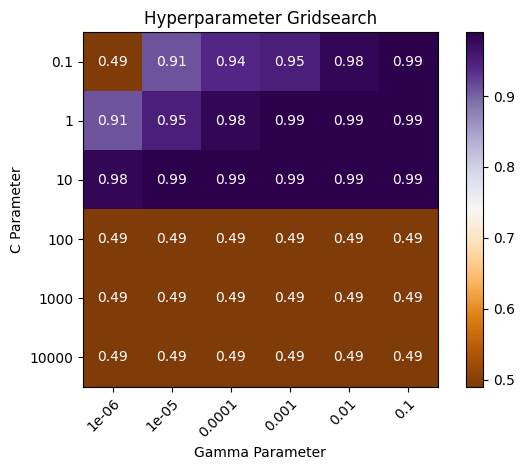

In [165]:
from matplotlib import pyplot as plt #plot grid table
fig, ax = plt.subplots()
im = ax.imshow(s_only,  cmap="PuOr")
ax.set_xticks(np.arange(len(gamma)), labels=gamma)
ax.set_yticks(np.arange(len(c)), labels=c)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(gamma)):
    for j in range(len(c)):
        text = ax.text(j, i, s_only[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Hyperparameter Gridsearch")
plt.xlabel('Gamma Parameter')
plt.ylabel('C Parameter')
cbar = ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [24]:
best_model = SVC(C=1, kernel='rbf', gamma=0.0001)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)


In [171]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined